In [1]:
from tarfile import data_filter

import pandas as pd
import numpy as np
import importlib
from datetime import datetime
import matplotlib.pyplot as plt
from dask.dataframe import read_csv
from matplotlib.pyplot import xticks
from numpy.ma.core import cumsum
from pandas.core.interchange.dataframe_protocol import DataFrame
from ply.cpp import xrange
from pygments.lexer import bygroups

import volpy_func_lib as vp
import load_clean_lib
import table_lib
import vol_strat_lib as vs

from datetime import datetime
from volpy_func_lib import load_forward_price

In [7]:
importlib.reload(vp)
importlib.reload(load_clean_lib)
importlib.reload(table_lib)
importlib.reload(vs)

<module 'vol_strat_lib' from 'D:\\Professionelt\\Code\\volpy\\vol_strat_lib.py'>

# Load Data

In [3]:
om_folder = "i2s1_full_v2" #SPX_full, i2s1_full_v2
sum_df, od_raw = vs.import_sum_raw(om_folder = om_folder)

In [4]:
price_type = "mid"
IV_type = "om"

od_hl = vs.create_od_hl(od_raw = od_raw, sum_df = sum_df, price_type = price_type, IV_type = IV_type)
sum_df = vs.add_F_to_sum_df(od_hl = od_hl, sum_df = sum_df)
sum_df = vs.add_ATM_options_to_sum_df(sum_df = sum_df, od_hl = od_hl, od_raw = od_raw)

# Add strategy cashflows

In [34]:
importlib.reload(vp)
importlib.reload(load_clean_lib)
importlib.reload(table_lib)
importlib.reload(vs)

strategies = [vs.add_put_and_call_sgy, vs.add_delta_put_and_call_sgy, vs.add_straddle_sgy, vs.add_delta_straddle_sgy, vs.add_self_financed_stock_sgy]
for add_sgy in strategies:
    sum_df = add_sgy(sum_df)

### Limit to ticker subset (SPX) ect. if wanted

In [38]:
df = sum_df[sum_df["ticker"] == "SPX"].reset_index(drop=True)
# df = sum_df

# No hedge

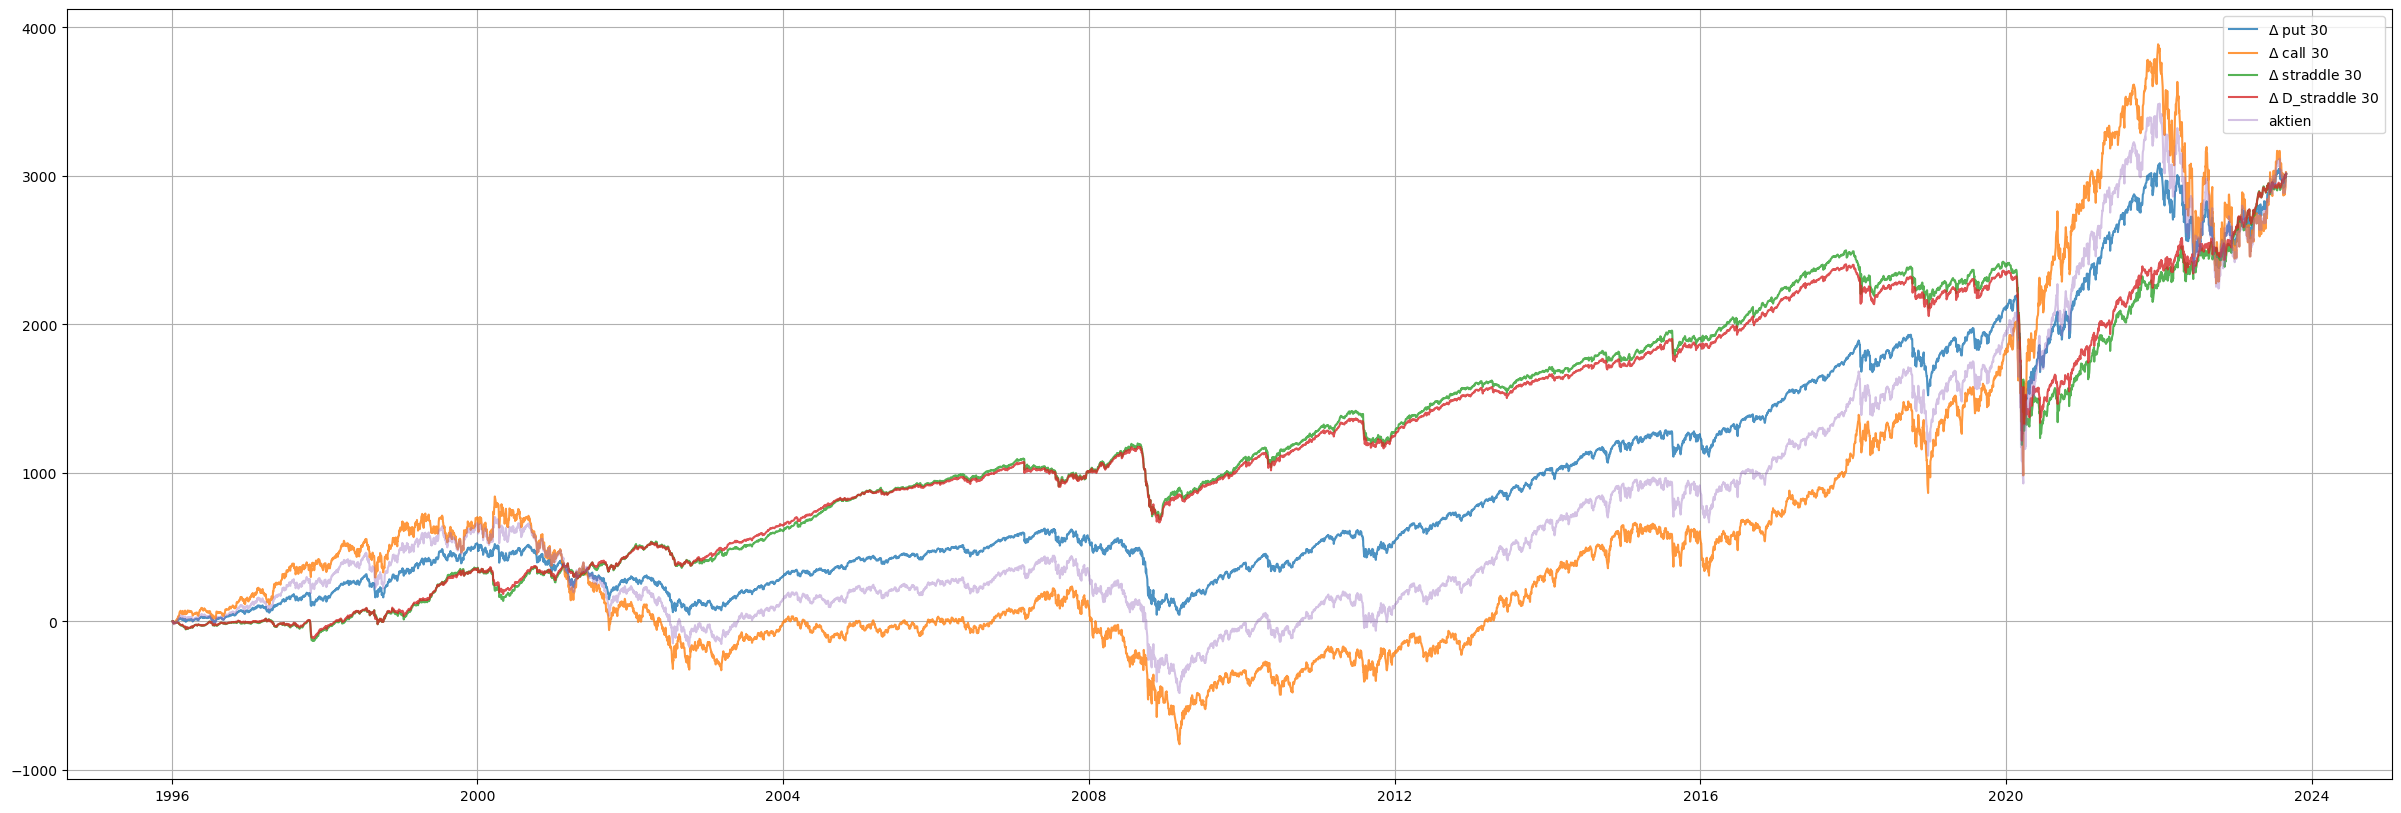

In [40]:
plt.figure(figsize=(30, 10))

last_stock_val = np.cumsum(df["ticker_change_free"]).iloc[-1]
    
for put_call in ["put", "call", "straddle", "D_straddle"]:
    last_option_val = np.cumsum(df[f"30_{put_call}"]).iloc[-1]
    scalar = last_stock_val/last_option_val
    plt.plot(df["date"], scalar * np.cumsum(df[f"30_{put_call}"]),
         label=rf"$\Delta$ {put_call} 30", alpha=0.8)

plt.plot(df["date"], np.cumsum(df["ticker_change_free"]),
    label="aktien", alpha=0.4)

plt.grid()
plt.legend()
plt.show()

# Plot accumulated cashflow

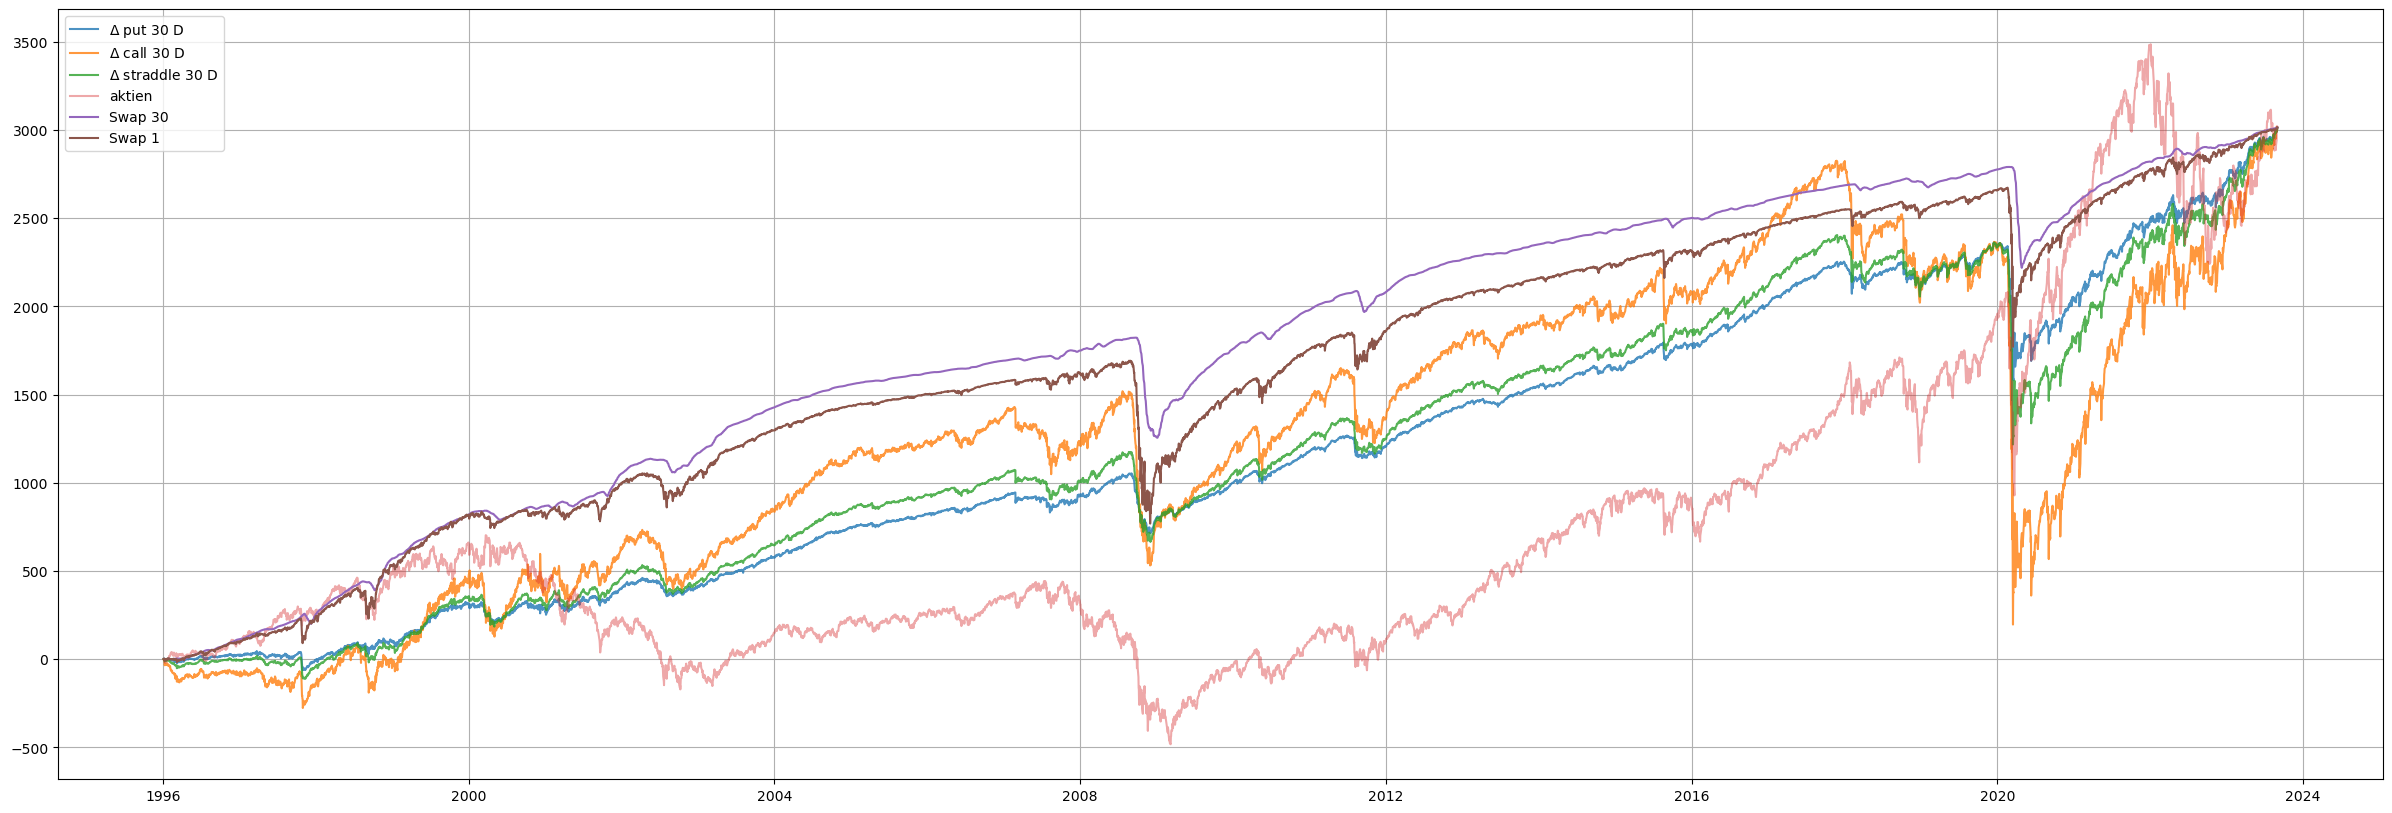

In [42]:
plt.figure(figsize=(30, 10))

last_stock_val = np.cumsum(df["ticker_change_free"]).iloc[-1]
    
for put_call in ["put", "call", "straddle"]:
    last_option_val = np.cumsum(df[f"30_D_{put_call}"]).iloc[-1]
    scalar = last_stock_val/last_option_val
    plt.plot(df["date"], scalar * np.cumsum(df[f"30_D_{put_call}"]),
         label=rf"$\Delta$ {put_call} 30 D", alpha=0.8)

plt.plot(df["date"], np.cumsum(df["ticker_change_free"]),
    label="aktien", alpha=0.4)

x_SW = df["SW_month"]
last_val = np.cumsum(x_SW).iloc[-1]
scalar = last_stock_val/last_val
plt.plot(df["date"], scalar * np.cumsum(x_SW), label = "Swap 30")

df["SW_day_new"] = df["SW_day"]
x_SW_dly = df["SW_day_new"]
last_val = np.cumsum(x_SW_dly).iloc[-1]
scalar = last_stock_val/last_val
plt.plot(df["date"], scalar * np.cumsum(x_SW_dly), label = "Swap 1")

plt.grid()
plt.legend()
plt.show()

# Current front page for LaTeX

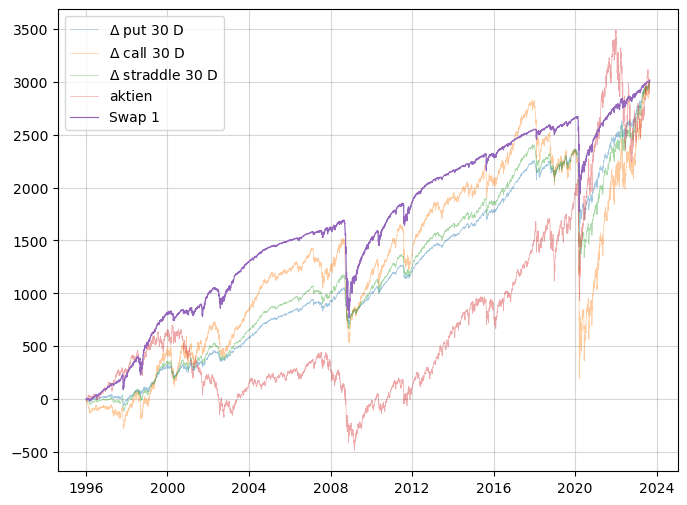

In [43]:
plt.figure(figsize=(8, 6))

lw = 0.5
last_stock_val = np.cumsum(df["ticker_change_free"]).iloc[-1]
    
for put_call in ["put", "call", "straddle"]:
    last_option_val = np.cumsum(df[f"30_D_{put_call}"]).iloc[-1]
    scalar = last_stock_val/last_option_val
    plt.plot(df["date"], scalar * np.cumsum(df[f"30_D_{put_call}"]),
         label=rf"$\Delta$ {put_call} 30 D", alpha=0.4, linewidth=lw)

plt.plot(df["date"], np.cumsum(df["ticker_change_free"]),
    label="aktien", alpha=0.4, linewidth=lw)

# x_SW = df["SW_month"]
# last_val = np.cumsum(x_SW).iloc[-1]
# scalar = last_stock_val/last_val
# plt.plot(df["date"], scalar * np.cumsum(x_SW), label = "Swap 30")

df["SW_day_new"] = df["SW_day"]
x_SW_dly = df["SW_day_new"]
last_val = np.cumsum(x_SW_dly).iloc[-1]
scalar = last_stock_val/last_val
plt.plot(df["date"], scalar * np.cumsum(x_SW_dly), label = "Swap 1", linewidth=1.75*lw, alpha=1)

plt.grid(alpha=0.5)
plt.legend()
plt.savefig("figures/acc fig.pdf")
plt.show()

# Random Stuff from here

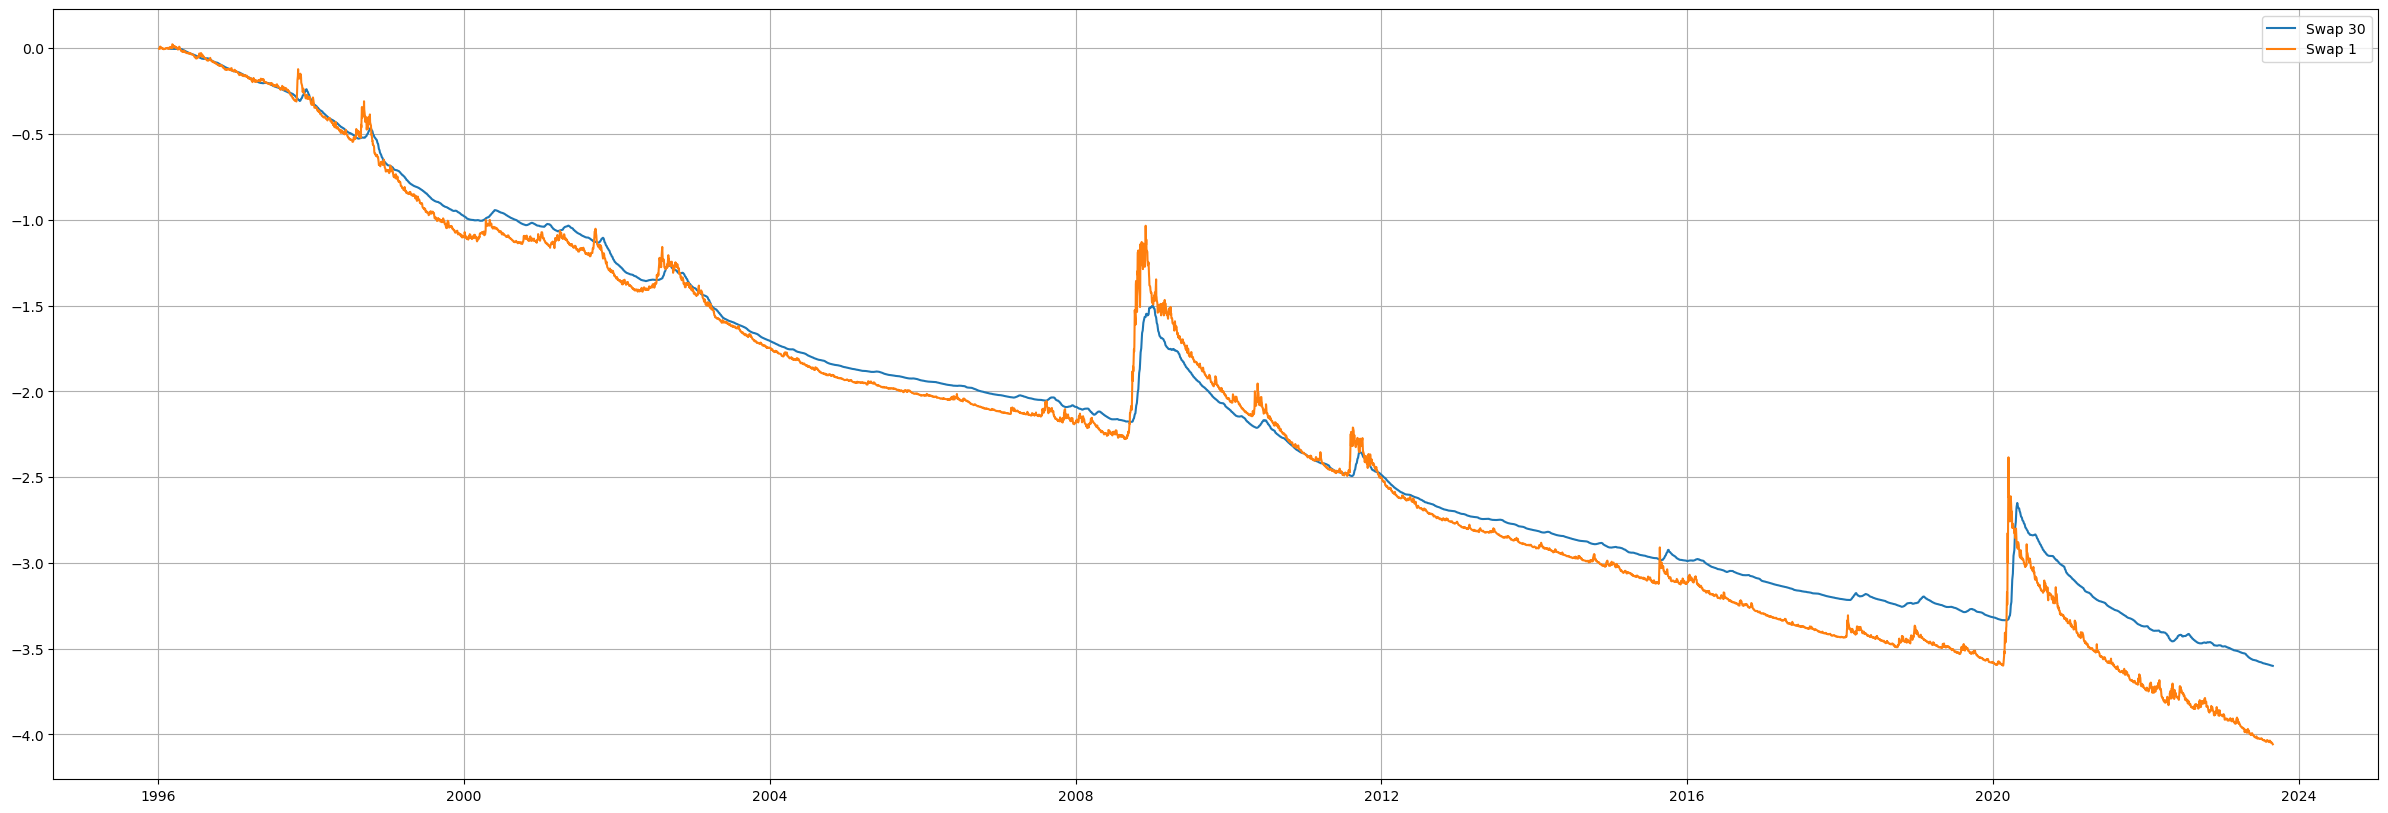

In [44]:
plt.figure(figsize=(30, 10))

last_stock_val = np.cumsum(df["ticker_change_free"]).iloc[-1]
    
# for put_call in ["put", "call", "straddle"]:
#     plt.plot(df["date"], np.cumsum(df[f"30_D_{put_call}"]),
#          label=rf"$\Delta$ {put_call} 30 D", alpha=0.8)

# plt.plot(df["date"], np.cumsum(df["ticker_change_free"]),
#     label="aktien", alpha=0.4)

x_SW = df["SW_month"]
plt.plot(df["date"], np.cumsum(x_SW/21), label = "Swap 30")

df["SW_day_new"] = df["SW_day"]
x_SW_dly = df["SW_day_new"]
plt.plot(df["date"], np.cumsum(x_SW_dly), label = "Swap 1")

plt.grid()
plt.legend()
plt.show()

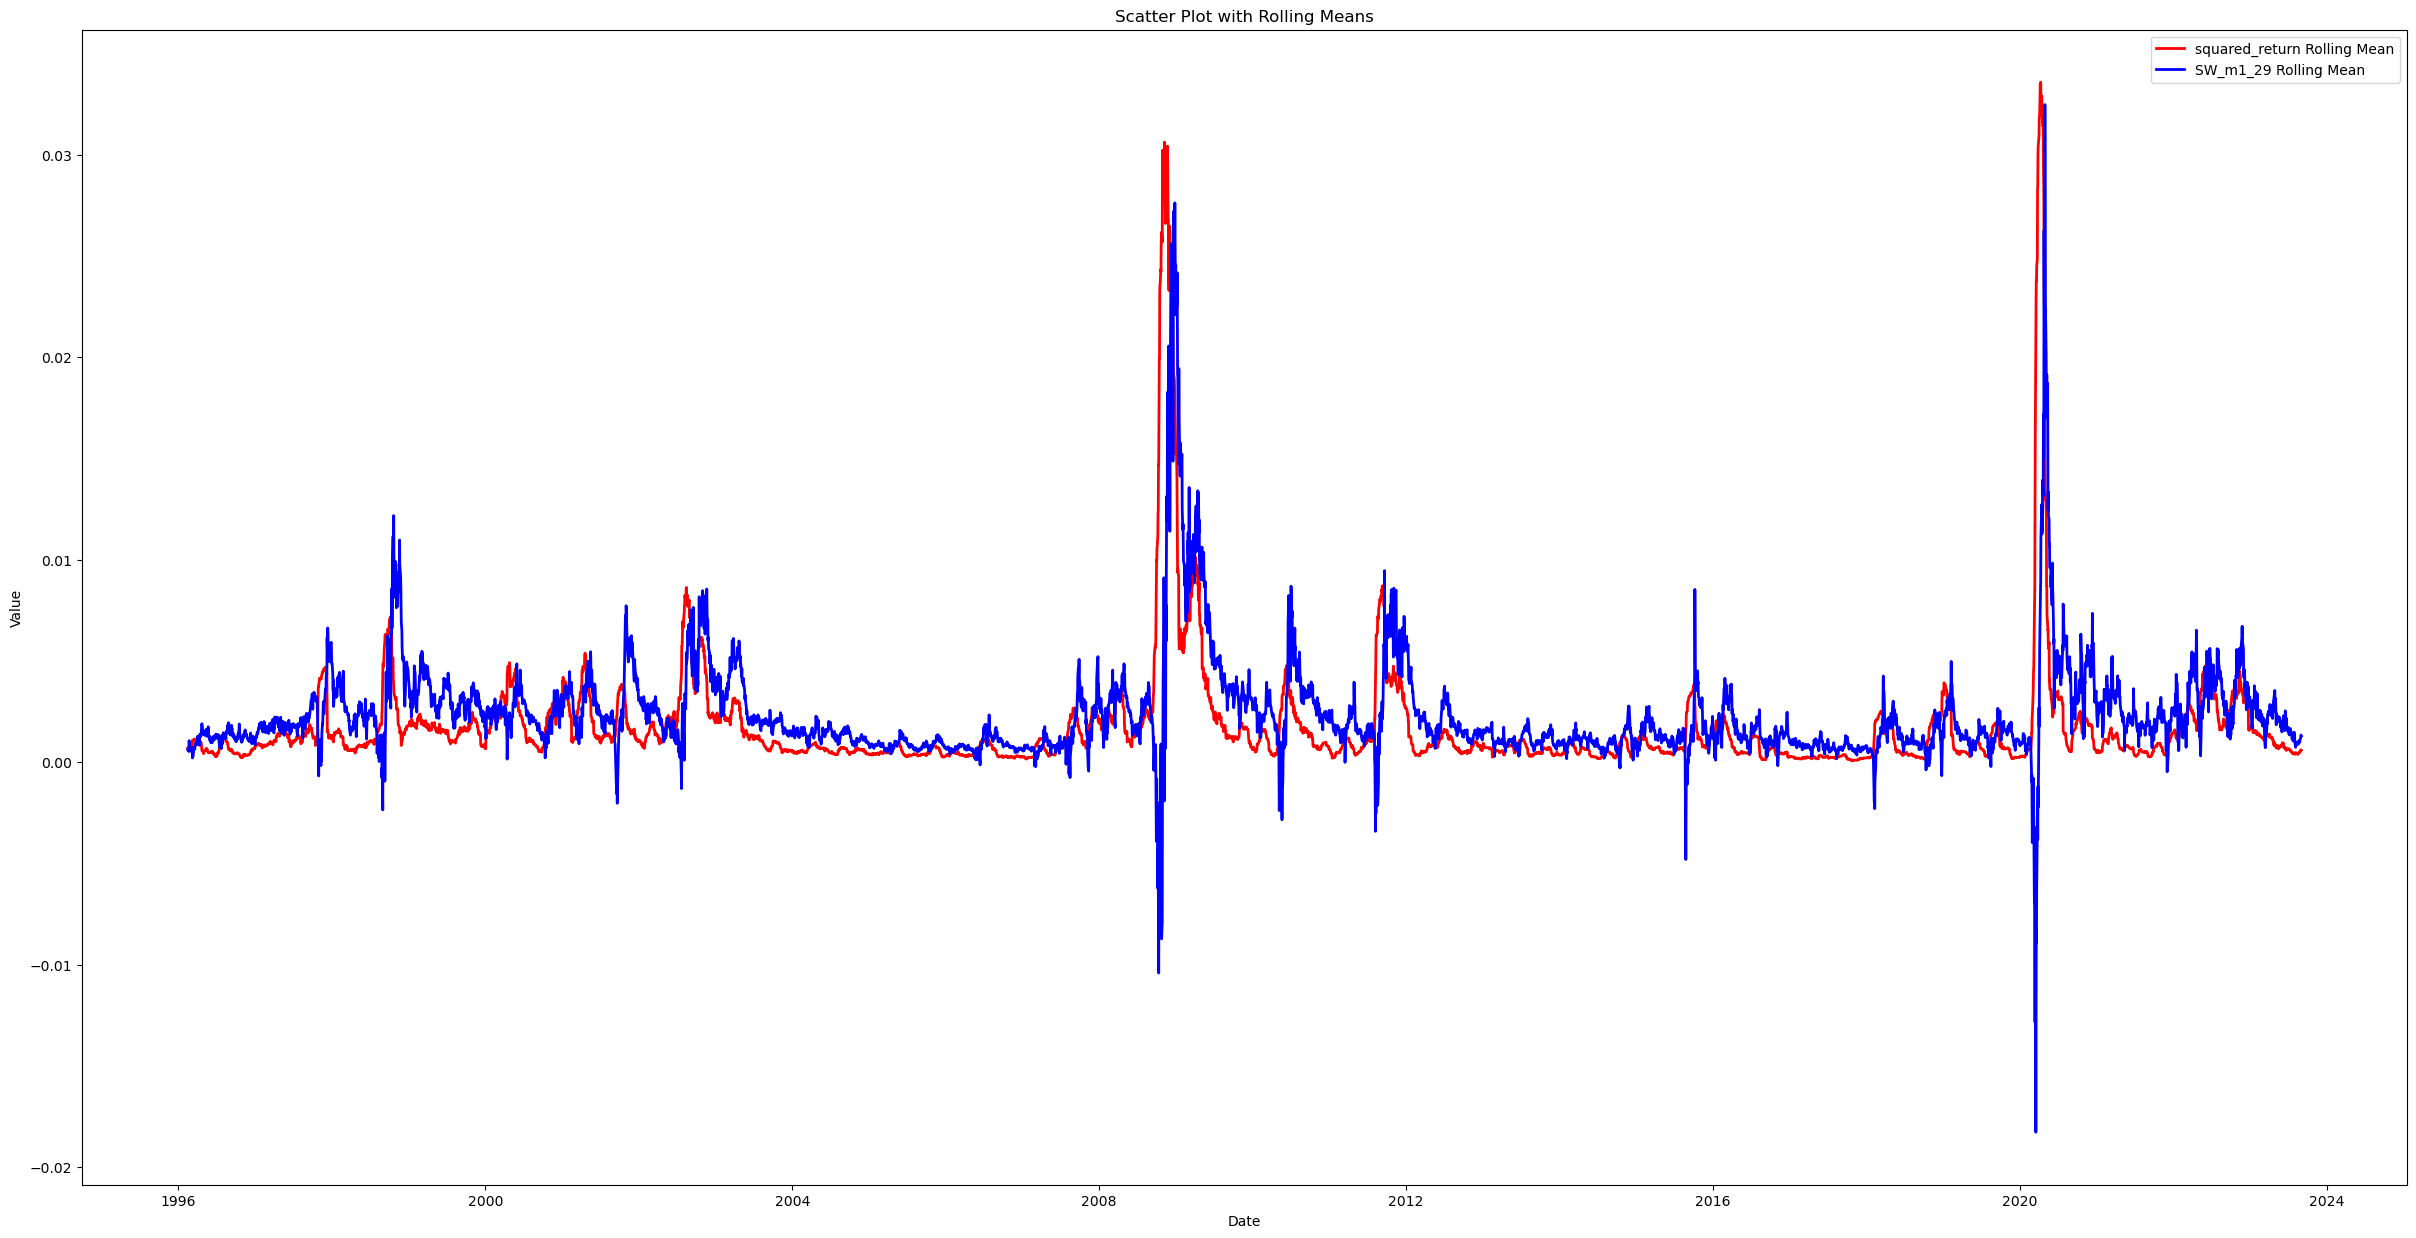

In [45]:
yr = df["date"].dt.year
df = df#[yr == 2020]

# Define the rolling window size (e.g., 20 days)
window_size = 30

# Compute the rolling mean for each series
df["squared_return_rolling"] = (252/21 * df["squared_return"]).rolling(window=window_size).mean()
df["SW_m1_rolling"] = (df["SW_m1_29"]-df["SW_0_29"]*20/21).rolling(window=window_size).mean()

# Create the plot
plt.figure(figsize=(30,15))

# # Scatter plots of the raw data
# plt.scatter(df["date"], 252 * df["squared_return"], label="squared_return", alpha=0.3)
# plt.scatter(df["date"], df["SW_m1_29"], label="SW_0_29", alpha=0.3)

# Line plots for the rolling means
plt.plot(df["date"], df["squared_return_rolling"], label="squared_return Rolling Mean", color="red", linewidth=2)
plt.plot(df["date"], df["SW_m1_rolling"], label="SW_m1_29 Rolling Mean", color="blue", linewidth=2)

# Adding labels and legend
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Scatter Plot with Rolling Means")
plt.legend()
plt.show()

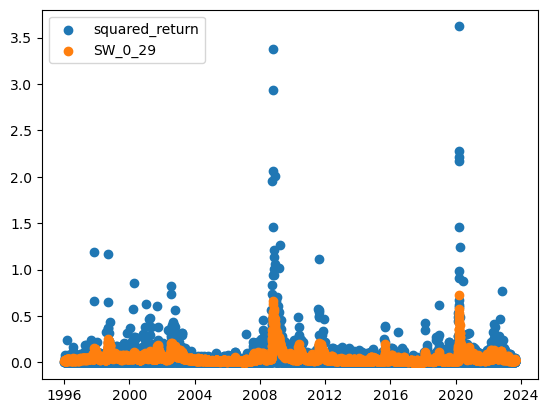

In [46]:
yr = df["date"].dt.year
df = df#[yr == 2020]
plt.scatter(df["date"], (252 * df["squared_return"]), label = "squared_return")
plt.scatter(df["date"], (df["SW_m1_29"]), label = "SW_0_29")
plt.legend()

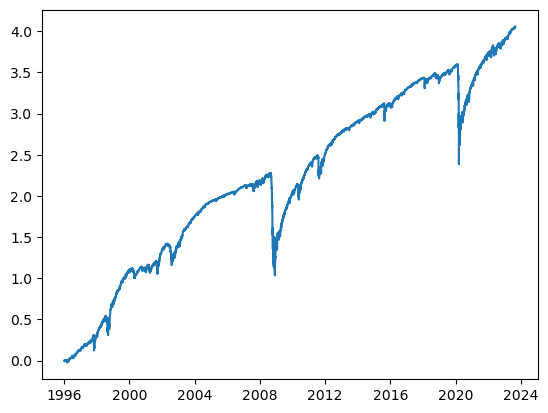

In [47]:
plt.plot(df["date"], np.cumsum(df["SW_m1_29"]-20/21*df["SW_0_29"]-252/21*df["squared_return"]), label = "SW_m1_29 - SW_0_29")

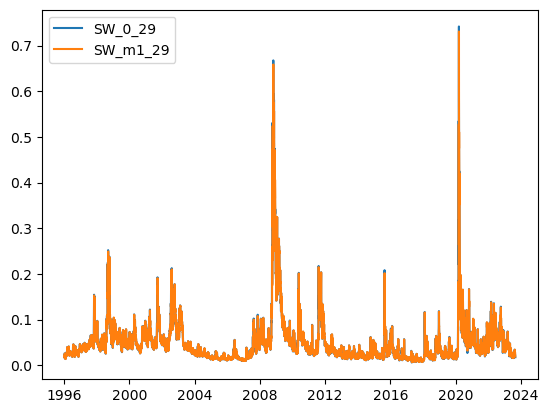

In [48]:
# plt.plot(df["date"], 252*df["squared_return"], label = "squared_return")
plt.plot(df["date"], df["SW_0_29"], label = "SW_0_29")
plt.plot(df["date"], df["SW_m1_29"], label = "SW_m1_29")
plt.legend()
plt.show()

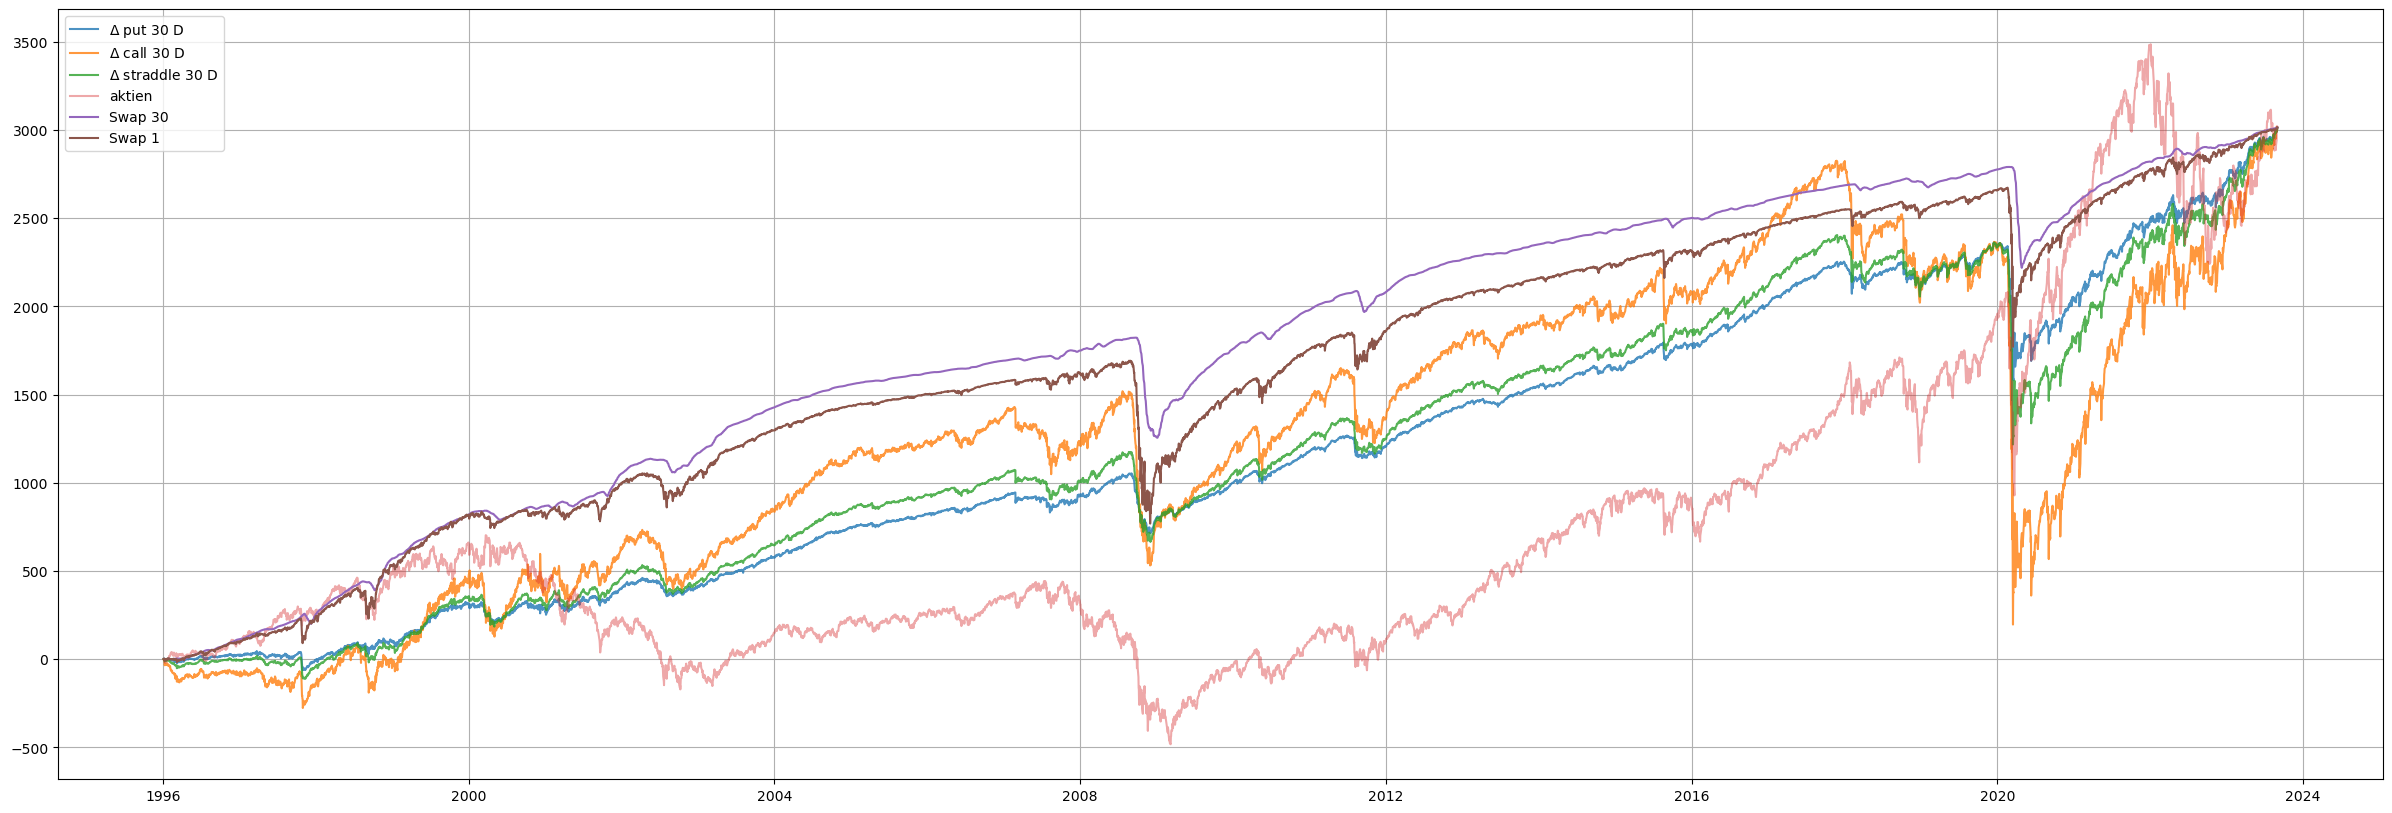

In [49]:
plt.figure(figsize=(30, 10))

last_stock_val = np.cumsum(df["ticker_change_free"]).iloc[-1]
    
for put_call in ["put", "call", "straddle"]:
    last_option_val = np.cumsum(df[f"30_D_{put_call}"]).iloc[-1]
    scalar = last_stock_val/last_option_val
    plt.plot(df["date"], scalar * np.cumsum(df[f"30_D_{put_call}"]),
         label=rf"$\Delta$ {put_call} 30 D", alpha=0.8)

plt.plot(df["date"], np.cumsum(df["ticker_change_free"]),
    label="aktien", alpha=0.4)

x_SW = df["SW_month"]
last_val = np.cumsum(x_SW).iloc[-1]
scalar = last_stock_val/last_val
plt.plot(df["date"], scalar * np.cumsum(x_SW), label = "Swap 30")

df["SW_day_new"] = df["SW_day"]
x_SW_dly = df["SW_day_new"]
last_val = np.cumsum(x_SW_dly).iloc[-1]
scalar = last_stock_val/last_val
plt.plot(df["date"], scalar * np.cumsum(x_SW_dly), label = "Swap 1")

plt.grid()
plt.legend()
plt.show()

# Other figures

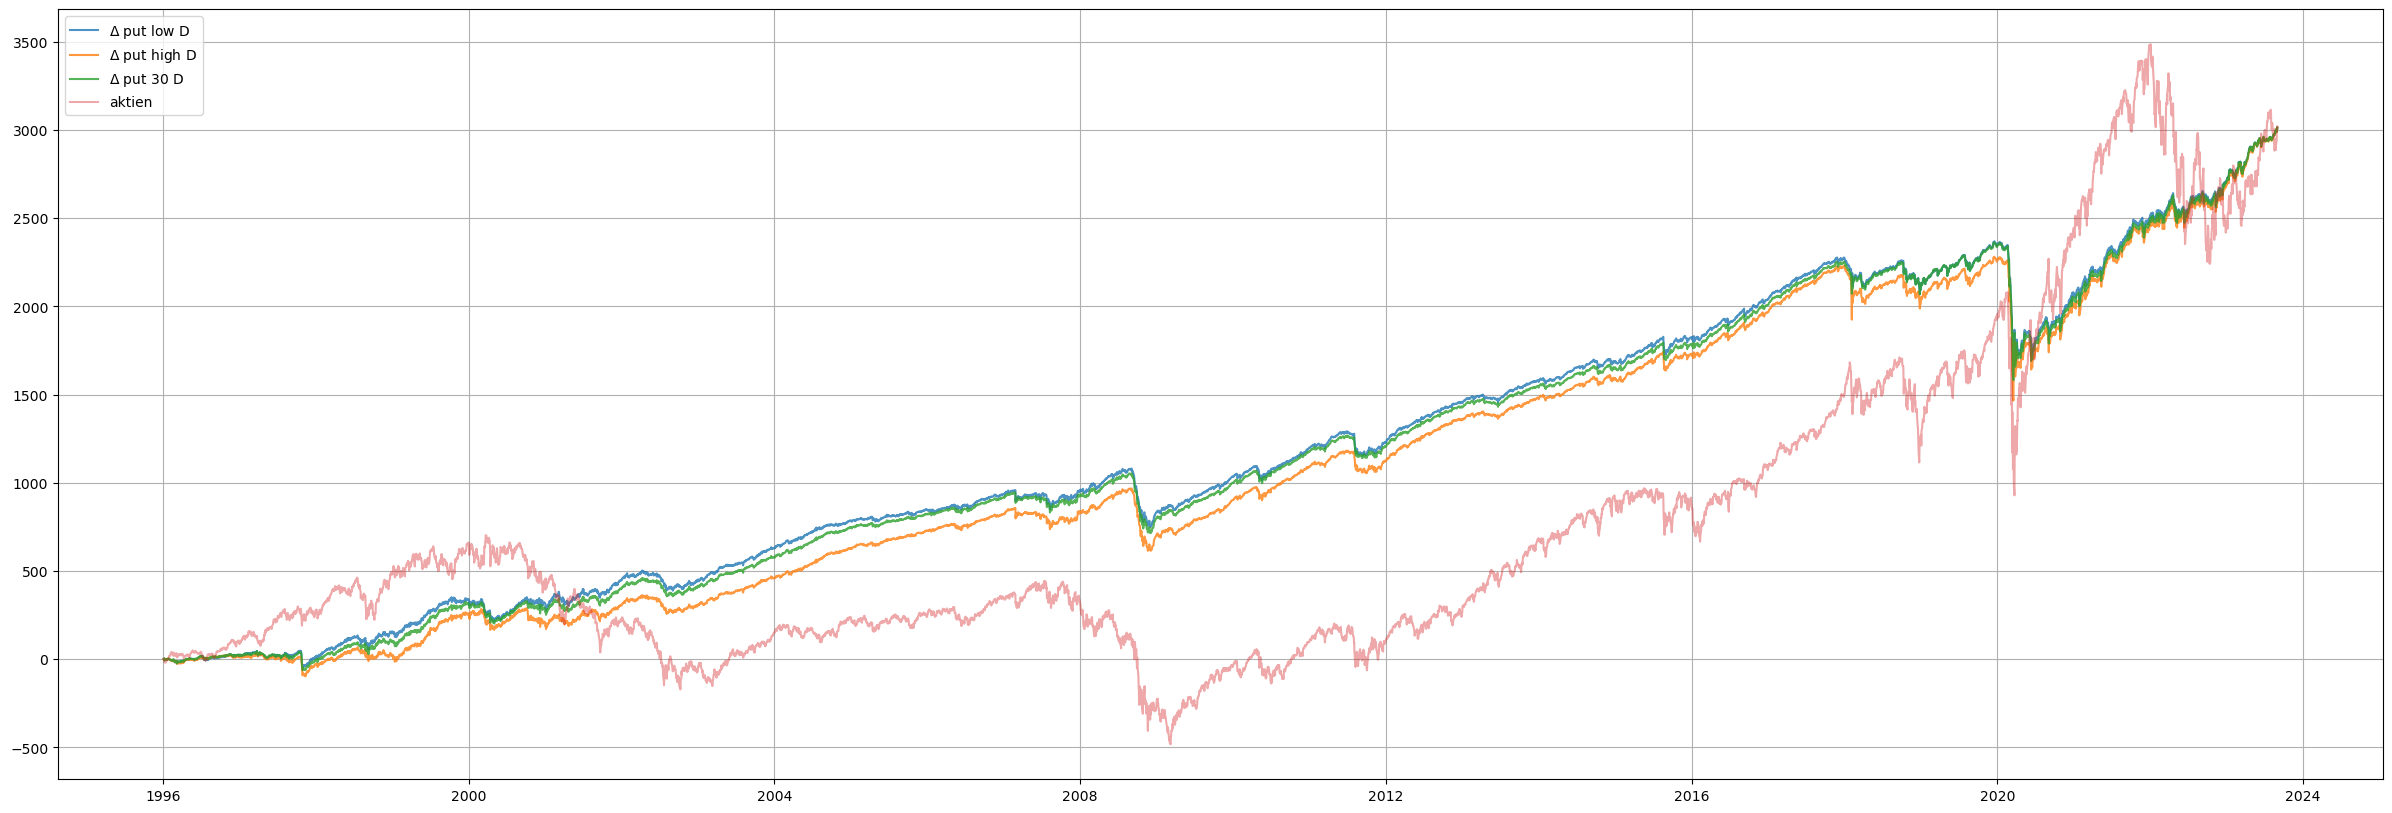

In [50]:
plt.figure(figsize=(30, 10))

last_stock_val = np.cumsum(df["ticker_change_free"]).iloc[-1]

put_call = "put"

for low_high in ["low", "high"]:
    last_option_val = np.cumsum(df[f"free_D_{low_high}_{put_call}"]).iloc[-1]
    scalar = last_stock_val/last_option_val
    plt.plot(df["date"], scalar * np.cumsum(df[f"free_D_{low_high}_{put_call}"]),
         label=rf"$\Delta$ {put_call} " + low_high + " D", alpha=0.8)
    
last_option_val = np.cumsum(df[f"30_D_{put_call}"]).iloc[-1]
scalar = last_stock_val/last_option_val

plt.plot(df["date"], scalar * np.cumsum(df[f"30_D_{put_call}"]),
     label=rf"$\Delta$ {put_call} 30 D", alpha=0.8)

plt.plot(df["date"], np.cumsum(df["ticker_change_free"]),
    label="aktien", alpha=0.4)

plt.grid()
plt.legend()
plt.show()